In [1]:
%load_ext autoreload
%autoreload 2

from dataset.chains import SimpleSynth
from torchsynth.config import SynthConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyheaven import *
from dataset import DATASET_MAPPING, DATASET_PATHS
from interface.torchsynth import REG_NCLASS
from utils.loss_utils import CLAPLoss
from interface.torchsynth import TorchSynthInterface

import os
import torch
import torchaudio
from pytorch_lightning import Trainer
from dataset import DATASET_MAPPING, DATASET_PATHS
from interface import INTERFACE_MAPPING
from model import Net, get_backbone, get_classifier
from sound2synth import Sound2SynthModel
from pyheaven import *

from preprocess.audio_to_many import audio_to_features
import torchsynth

    
def softargmax1d(input, beta=100):
    *_, n = input.shape
    input = nn.functional.softmax(beta * input, dim=-1)
    indices = torch.linspace(0, 1, n, device=input.device, dtype=input.dtype)
    result = torch.sum((n - 1) * input * indices, dim=-1)
    return result

def parse_outputs(outputs, unnormalizer, logits, from_0to1):
    n_params = len(unnormalizer)
    # print(n_params)
    if logits:
        outputs = torch.stack(outputs.squeeze(0).chunk(n_params, dim=-1))
        outputs = softargmax1d(outputs) / (outputs.shape[-1] - 1)
        nan_mask = torch.isnan(outputs)
        outputs[nan_mask] = 0.5

    mydict = {}
    assert len(unnormalizer) == len(
        outputs
    ), f"Length mismatch: {len(unnormalizer)} vs {len(outputs)}"
    for (k, f), v in zip(unnormalizer.items(), outputs):
        if "keyboard" in k:
            continue  # Skip keyboard parameters as they are initialized frozen
        mydict[k] = f.from_0to1(v.unsqueeze(0)) if from_0to1 else v.unsqueeze(0)
    return mydict

def load_checkpoint(checkpoint_path, args):
    interface = INTERFACE_MAPPING[args.synth]
    net = Net(
        backbone=get_backbone(args.backbone, args),
        classifier=get_classifier(args.classifier, interface, args),
    )
    if checkpoint_path is not None:
        model = Sound2SynthModel.load_from_checkpoint(checkpoint_path, net=net, interface=interface, args=args)
    else:
        model = Sound2SynthModel(net=net, interface=interface, args=args)
    model.eval()
    return model

def save_wavs(audio, path, name):
    os.makedirs(path, exist_ok=True)
    filepath = os.path.join(path, f"{name}.wav")
    torchaudio.save(filepath, audio, 48000)

args = MemberDict(dict(
        synth="TorchSynth",
        synth_class="Voice",
        backbone="multimodal",
        classifier="parameter",
        dataset_type="vengeance",
        dataset="Vengeance",
        feature_dim=2048,
))

loss_fn = CLAPLoss(synth=args.synth_class)
data_dir = lambda dataset: "data/" + dataset if dataset != "Vengeance" else dataset + "/processed"
dataset = DATASET_MAPPING[args.dataset_type](dir=data_dir(args.dataset), chain=args.synth_class, split='train')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)

/home/ubuntu/anaconda3/envs/sound2synth/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
Voice synthesizer initialized on cuda:0


In [2]:
from model.myModel import myBackbone
from utils.loss_utils import AudioLoss, CLAPLoss
from transformers.debug_utils import DebugUnderflowOverflow

torch.autograd.set_detect_anomaly(True)

device = 'cuda'
model = myBackbone(modalities=['spec_amp','mel_amp','spec_rms','mel_rms','zcr','rms','flatness'], interface=TorchSynthInterface)
model = model.to(device)
_ = DebugUnderflowOverflow(model)
# loss_fn = AudioLoss(scales=[2048, 1024, 512, 256, 128, 64], synth='Voice')
loss_fn = CLAPLoss(synth='Voice')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

for i, batch in enumerate(dataloader):
    (features, sample_rate), labels = batch
    for k in features:
        features[k] = features[k].to(device) if isinstance(features[k], torch.Tensor) else features[k]
    out = model(features)
    pred_audio, params = loss_fn.params_to_audio(out.T, loss_fn.unnormalizer, logits=False, from_0to1=False)
    # print(out.shape, pred_audio.shape, features['audio'].shape, pred_audio.device, features['audio'].device)
    loss = loss_fn.forward(pred_audio, features['audio'].to('cuda'), from_params='pass')

    loss.backward()
    # clip gradients
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # Print parameters with large grads
    # for name, param in model.named_parameters():
    #     if param.grad is not None and torch.max(param.grad) > 1:
    #         print(name, torch.max(param.grad))
    
    optimizer.step()
    optimizer.zero_grad()
    if i % 10 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")
    # break

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
Voice synthesizer initialized on cuda:0
Step 0, Loss: 0.0400
Step 10, Loss: 0.0429


KeyboardInterrupt: 

In [ ]:
max_val = -1e9
min_val = 1e9
for i, batch in enumerate(dataloader):
    (features, sample_rate), labels = batch
    
    a_max = torch.max(features['audio'])
    a_min = torch.min(features['audio'])
    if a_max > max_val:
        max_val = a_max
    if a_min < min_val:
        min_val = a_min
        
    if i % 10 == 0:
        print(f"Step {i}, Max: {max_val}, Min: {min_val}")

In [ ]:
# reconstruct samples from dataset
if True:
    checkpoint_path = "/home/ubuntu/Sound2Synth/checkpoints/Voice_AudioLoss/ckpt-epoch=44-valid_celoss=1.00.ckpt"  # "./checkpoints/SimpleSynth_CosimLoss_NoPDCMFCC/ckpt-epoch=07-valid_celoss=1.00.ckpt"  # Replace with the actual path to the checkpoint
    output_dir = "output_wavs"
    model = load_checkpoint(checkpoint_path, args)

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            if idx >= 5:  # Iterate through 5 samples
                break
            (features, sample_rate), label = batch
            outputs = model(features)
            true_params = label[0].squeeze(0)
            parsed_outputs, _ = loss_fn.params_to_audio(
                outputs, loss_fn.unnormalizer, logits=True, from_0to1=True
            )
            parsed_true_params, _ = loss_fn.params_to_audio(
                true_params,
                loss_fn.unnormalizer,
                logits=False,
                from_0to1=(true_params.max() <= 1).item(),
            )

            save_wavs(
                parsed_true_params.cpu().detach()[:1], output_dir, f"ground_truth_{idx}"
            )
            save_wavs(
                parsed_outputs.cpu().detach()[:1], output_dir, f"reconstruction_{idx}"
            )
            print(f"Saved sample {idx}")

In [10]:
import torch
a = torch.load("Vengeance/processed/VPE1_Vengeance_Pop_Essentials_Vol_1/VPE1 Construction Kits/VPE1 128BPM French Kit Root E/VPE1 128BPM French Mix.pt")
a['spec_rms'].shape

from dataset.my_multimodal import VengeanceDataset
dataset = VengeanceDataset(dir="Vengeance/processed", chain="Voice", split="train")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)
print(len(dataset.files))
for b in dataloader:
    (features, sr), label = b
    print(features["spec_rms"].shape)
    break

89181
torch.Size([16, 376, 1])


In [4]:
import torch
from pyheaven import *
from dataset import DATASET_MAPPING
import torchaudio

args = MemberDict(dict(dataset_type="vengeance", dataset="Vengeance", synth_class="Voice"), synth="TorchSynth", classifier="parameter", backbone="multimodal", multimodal_use_spec=True)
data_dir = lambda dataset: "data/" + dataset if dataset != "Vengeance" else dataset + "/processed"
dataset = DATASET_MAPPING[args.dataset_type](dir=data_dir(args.dataset), chain=args.synth_class, split='train')
dataset.__iter__()
(a, b), c = dataset.__next__()
# print(a.keys(), b ,c)
# torch.max(torch.concat([a[k] for k in a], dim=-1)), torch.min(torch.concat([a[k] for k in a], dim=-1)), torch.mean(torch.concat([a[k] for k in a], dim=-1)), torch.std(torch.concat([a[k] for k in a], dim=-1))

RuntimeError: zero-dimensional tensor (at position 12) cannot be concatenated

In [ ]:
for i, f in enumerate(dataset.files):
    f = f.split("/")
    # remove 2nd and 3rd elements
    f = f[:1] + f[3:]
    f = "/".join(f)
    f = f[:-3] + ".wav"
    
    try:
        # torch.load(f)
        a, sr = torchaudio.load(f)
    except:
        print(f)
    if i %1000 == 0:
        print(i)

In [17]:
args = MemberDict(dict(dataset_type="my_multimodal", dataset="Voice", synth_class="Voice"))
data_dir = lambda dataset: "data/" + dataset if dataset != "Vengeance" else dataset + "/processed"
dataset = DATASET_MAPPING[args.dataset_type](dir=data_dir(args.dataset), chain=args.synth_class, split='train')
dataset.__iter__()
(d, e), f = dataset.__next__()
# print(d.keys(),e, f)
torch.max(torch.concat([d[k] for k in d], dim=-1)), torch.min(torch.concat([d[k] for k in d], dim=-1)), torch.mean(torch.concat([d[k] for k in d], dim=-1)), torch.std(torch.concat([d[k] for k in d], dim=-1))

/home/ubuntu/Sound2Synth/dataset/my_multimodal.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features[key] = torch.tensor(features[key]) if isinstance(features[key], torchsynth.signal.Signal) else features[key]


(tensor(1.), tensor(-0.9594), tensor(-0.2314), tensor(0.4090))

In [ ]:
# reconstruct OOD audio samples
if True:
    checkpoint_path = "/home/ubuntu/Sound2Synth/checkpoints/Synplant_norm_big/ckpt-epoch=04-valid_celoss=0.92.ckpt"  # "./checkpoints/SimpleSynth_CosimLoss_NoPDCMFCC/ckpt-epoch=07-valid_celoss=1.00.ckpt"  # Replace with the actual path to the checkpoint
    output_dir = "samples"
    input_dir = "samples"
    model = load_checkpoint(checkpoint_path, args)

    samples = os.listdir(input_dir) # List of audio sample paths
    samples = [sample for sample in samples if 'reconstruction' not in sample]

    with torch.no_grad():
        for idx, sample in enumerate(samples):
            features = audio_to_features(os.path.join(input_dir, sample), from_wav=True)
            sample_rate = features.pop("sample_rate")
            label = features.pop("label")

            for key in features:
                features[key] = torch.tensor(features[key]) if isinstance(features[key], torchsynth.signal.Signal) else features[key]
                features[key] = features[key].unsqueeze(0).detach()

            outputs = model(features)
            true_params = label[0].squeeze(0)
            parsed_outputs, _ = loss_fn.params_to_audio(
                outputs, loss_fn.unnormalizer, logits=True, from_0to1=True
            )
            save_wavs(
                parsed_outputs.cpu().detach()[:1], output_dir, f"reconstruction_{sample[:-4]}"
            )
            print(f"Saved sample {idx}")

In [3]:
# debug loss
batch_size = 16
interface = TorchSynthInterface
criteria = interface.criteria
gradients = [{key: 1 for key in interface.parameters()} for _ in range(batch_size)]
weights = {
    key: torch.tensor([g[key] for g in gradients], dtype=torch.float)
    for key in interface.parameters()
}
w = {k: w.detach().to('cuda') for k, w in weights.items()}

# loss_fn = AudioLoss(scales=[2048, 1024, 512, 256, 128, 64], synth="SimpleSynth")

model = torch.nn.Linear(704, 704).to('cuda')
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

input_ = torch.rand((batch_size, 704), requires_grad=True).to("cuda")

# one hot
true = torch.arange(0, 704)
true = ((true % 64) == 0).float().unsqueeze(0).repeat(batch_size, 1).requires_grad_().to("cuda")

# # random
# true = torch.rand((batch_size, 704), requires_grad=True).to("cuda")
# true = ((true > 0.5).float()).to("cuda")

# true = torch.rand((batch_size, 704), requires_grad=True).to("cuda")
# print(true)

import time

for i in range(1000):
    # Start timing for forward pass
    start_time_forward = time.time()
    pred = model(input_)
    end_time_forward = time.time()

    # Start timing for loss computation
    start_time_loss = time.time()
    celoss = criteria(pred, true, w)
    # isolate_audioloss = loss_fn(pred, true)
    loss = criteria(pred, true, w, loss_type="audioloss")
    combined_loss = celoss + loss
    end_time_loss = time.time()

    # Start timing for backward pass
    start_time_backward = time.time()
    loss.backward()
    end_time_backward = time.time()

    # Start timing for optimizer step
    start_time_step = time.time()
    optim.step()
    end_time_step = time.time()

    # Print out timings for each step
    if i % 20 == 0:
        # print(f"Iteration {i}:")
        # print(
        #     f"  Forward Pass Time: {end_time_forward - start_time_forward:.4f} seconds"
        # )
        # print(f"  Loss Computation Time: {end_time_loss - start_time_loss:.4f} seconds")
        # print(
        #     f"  Backward Pass Time: {end_time_backward - start_time_backward:.4f} seconds"
        # )
        # print(f"  Optimizer Step Time: {end_time_step - start_time_step:.4f} seconds")
        # print(
        #     f"  Total Iteration Time: {end_time_step - start_time_forward:.4f} seconds"
        # )
        print(
            f"Iteration {i}, Audio Loss: {loss.item()}, Cross Entropy Loss: {celoss.item()}"
        )

ValueError: Last dimension must be > 1, got 0

In [ ]:
# traverse grad_fn
import torch
import torch.nn as nn

def traverse_grad_fn(grad_fn):
    if grad_fn is None:
        return
    ops = [grad_fn]
    while grad_fn is not None:
        ops.append(grad_fn)
        if hasattr(grad_fn, 'next_functions'):
            for f in grad_fn.next_functions:
                if f[0] is not None:
                    ops.extend(traverse_grad_fn(f[0]))
        grad_fn = None
    return ops

operations = traverse_grad_fn(loss.grad_fn)
print(len(operations))
# for op in operations:
#     print(op)


# Synplant Preset Analysis

In [2]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

folder_path = "Synplant Patches" # "New Loops - Pro Expansion"
files = {}

# Get folders in the specified folder
instruments = os.listdir(folder_path)

# Get the files for each instrument folder
for instrument in instruments:
    instrument_path = os.path.join(folder_path, instrument)

    # Ensure that the path is a directory before listing files
    if os.path.isdir(instrument_path):
        instrument_files = os.listdir(instrument_path)
        files[instrument] = [os.path.join(instrument_path, f) for f in instrument_files]

with open(files[instrument][0], "r", encoding="utf-8") as file:
    text = file.read()

In [3]:
def parse_synplant_patch(file_contents):
    def parse_value(value):
        if value.lower() == "true":
            return True
        elif value.lower() == "false":
            return False
        elif value.startswith("0x"):
            return value  # Keep hexadecimal as string
        try:
            return float(value)
        except ValueError:
            return value.strip('"')

    def parse_object(content):
        obj = {}
        for line in content.strip().split("\n"):
            line = line.strip()
            if ":" in line:
                key, value = line.split(":", 1)
                obj[key.strip()] = parse_value(value.strip())
        return obj

    def parse_array(content):
        items = re.findall(r"{[^}]*}", content)
        return [parse_object(item) for item in items]

    parsed_data = {}
    current_key = None
    current_content = ""

    for line in file_contents.split("\n"):
        line = line.strip()
        if line.endswith("{"):
            if current_key:
                if current_content.strip().startswith("{"):
                    parsed_data[current_key] = parse_array(current_content)
                else:
                    parsed_data[current_key] = parse_object(current_content)
            current_key = line[:-1].strip().rstrip(":")
            current_content = ""
        elif line == "}" and current_key:
            if current_content.strip().startswith("{"):
                parsed_data[current_key] = parse_array(current_content)
            else:
                parsed_data[current_key] = parse_object(current_content)
            current_key = None
            current_content = ""
        elif current_key is not None:
            current_content += line + "\n"
        elif ":" in line:
            key, value = line.split(":", 1)
            parsed_data[key.strip()] = parse_value(value.strip())

    return parsed_data


def generate_synplant_patch(parsed_data):
    def format_value(value):
        if isinstance(value, bool):
            return str(value).lower()
        elif isinstance(value, (int, float)):
            return str(value)
        elif isinstance(value, str) and value.startswith("0x"):
            return value
        else:
            return f'"{value}"'

    def format_object(obj, indent=""):
        lines = []
        for key, value in obj.items():
            if key in ["branches"]:
                lines.append(f"{indent}{key}: {{")
                for item in value:
                    lines.append(
                        f"{indent}\t {', '.join([f'{k}: {format_value(v)}' for k, v in item.items()])} "
                    )
                lines.append(f"{indent}}}")
            elif key in ["layers"]:
                lines.append(f"{indent}{key}: {{")
                for item in value:
                    lines.append(
                        f"{indent}\t {', '.join([f'{k}: {format_value(v)}' for k, v in item.items()])}"[:-1] + ","
                    )
                lines.append(f"{indent}}}")
            elif key in ["format", "implementation"]:
                lines.append(f"{indent}{key}: {format_value(int(value))}")
            elif isinstance(value, dict):
                lines.append(f"{indent}{key}: {{")
                lines.extend(format_object(value, indent + "\t"))
                lines.append(f"{indent}}}")
            elif isinstance(value, list):
                lines.append(f"{indent}{key}: {{")
                for item in value:
                    if isinstance(item, dict):
                        lines.extend(format_object(item, indent + "\t"))
                    else:
                        lines.append(f"{indent}\t{format_value(item)}")
                lines.append(f"{indent}}}")
            else:
                lines.append(f"{indent}{key}: {format_value(value)}")
        return lines

    output_lines = ["SynplantPatch: {"]
    output_lines.extend(format_object(parsed_data, "\t"))
    output_lines.append("}")

    return "\n".join(output_lines)

In [5]:
# Dictionary to store parameter values for each instrument
instrument_params = defaultdict(list)
instrument_controls = defaultdict(list)
instrument_probabilities = defaultdict(dict)

for instrument in instruments:
    for i in range(len(files[instrument])):
        with open(files[instrument][i], "r", encoding="utf-8") as file:
            file_contents = file.read()
        parsed_patch = parse_synplant_patch(file_contents)

        genome = parsed_patch["genome"]
        control = parsed_patch["control"]
        instrument_params[instrument].append(genome)
        instrument_controls[instrument].append(control)

# Number of bins
num_bins = 64

# Iterate over each instrument in the instrument_params
for instrument, params_list in instrument_params.items():
    # Get all parameter names from the first entry (assuming all entries have the same parameters)
    parameter_names = params_list[0].keys()

    # Iterate over each parameter
    for parameter_name in parameter_names:
        # Extract the specific parameter values from each dictionary in the params_list
        parameter_values = [params[parameter_name] for params in params_list]

        # Bin the data into 64 bins between 0 and 1
        counts, _ = np.histogram(parameter_values, bins=num_bins, range=(0, 1))

        # Calculate the probability distribution (normalized counts)
        probabilities = counts / counts.sum()

        # Store the probability distribution in the dictionary
        instrument_probabilities[instrument][parameter_name] = torch.tensor(
            probabilities, dtype=torch.float32
        )

In [28]:
# covariance distributions probability
import numpy as np
import torch
from collections import defaultdict
from itertools import combinations

# Dictionary to store parameter values for each instrument
instrument_params = defaultdict(list)
instrument_controls = defaultdict(list)
instrument_probabilities = defaultdict(dict)
instrument_covariances = defaultdict(dict)

for instrument in instruments:
    for i in range(len(files[instrument])):
        with open(files[instrument][i], "r", encoding="utf-8") as file:
            file_contents = file.read()
        parsed_patch = parse_synplant_patch(file_contents)

        genome = parsed_patch["genome"]
        control = parsed_patch["control"]
        instrument_params[instrument].append(genome)
        instrument_controls[instrument].append(control)

# Number of bins
num_bins = 64

# Iterate over each instrument in the instrument_params
for instrument, params_list in instrument_params.items():
    # Get all parameter names from the first entry (assuming all entries have the same parameters)
    parameter_names = list(params_list[0].keys())

    # Calculate univariate distributions
    for parameter_name in parameter_names:
        parameter_values = [params[parameter_name] for params in params_list]

        # Bin the data into 64 bins between 0 and 1
        counts, _ = np.histogram(parameter_values, bins=num_bins, range=(0, 1))

        # Calculate the probability distribution (normalized counts)
        probabilities = counts / counts.sum()

        # Store the probability distribution in the dictionary
        instrument_probabilities[instrument][parameter_name] = torch.tensor(
            probabilities, dtype=torch.float32
        )

    # Calculate pairwise covariances
    covariance_matrix = np.zeros((len(parameter_names), len(parameter_names)))

    for i, j in combinations(range(len(parameter_names)), 2):
        param_i_values = [params[parameter_names[i]] for params in params_list]
        param_j_values = [params[parameter_names[j]] for params in params_list]

        # Calculate covariance between parameter i and j
        covariance_matrix[i, j] = np.cov(param_i_values, param_j_values)[0, 1]
        covariance_matrix[j, i] = covariance_matrix[i, j]  # Symmetric matrix

    # Store covariance matrix for the instrument
    instrument_covariances[instrument] = torch.tensor(
        covariance_matrix, dtype=torch.float32
    )


# Sampling from the joint distribution considering the covariance matrix
def sample_from_distribution(instrument, num_samples=1):
    parameter_names = list(instrument_probabilities[instrument].keys())
    joint_samples = []

    for _ in range(num_samples):
        sample = []
        for i, param_name in enumerate(parameter_names):
            # Sample based on the univariate probability distribution
            probabilities = instrument_probabilities[instrument][param_name].numpy()
            bin_indices = np.arange(len(probabilities))
            sampled_bin = np.random.choice(bin_indices, p=probabilities)

            # Convert sampled bin to a value in the parameter range
            bin_start = sampled_bin / num_bins
            bin_end = (sampled_bin + 1) / num_bins
            sampled_value = np.random.uniform(bin_start, bin_end)
            sample.append(sampled_value)

        joint_samples.append(sample)

    # Convert list of samples to a numpy array and return
    return torch.tensor(joint_samples)


# Example usage

# print(sampled_values.shape)

for instrument in instrument_params.keys():
    for i in range(5):
        sampled_genome = {}

        # instrument = "Keys"
        with open(files[instrument][0], "r", encoding="utf-8") as file:
            file_contents = file.read()
        patch_scaffold = parse_synplant_patch(file_contents)

        distribution = instrument_probabilities[instrument]
        sampled_values = sample_from_distribution(instrument, num_samples=1)
        for (param, prob), pred_val in zip(distribution.items(), sampled_values.squeeze()):
            sampled_genome[param] = pred_val.item()

        patch_scaffold["genome"] = sampled_genome
        patch_scaffold.pop("SynplantPatch")
        # save the patch
        # Check if dir exists, if not create it
        os.makedirs(f"patches/{instrument}", exist_ok=True)
        with open(f"patches/{instrument}/patch_{i}.synplant", "w") as file:
            file.write(generate_synplant_patch(patch_scaffold))

In [34]:
# gibbs sampling
import numpy as np
import torch
from collections import defaultdict
from itertools import combinations

# Dictionary to store parameter values for each instrument
instrument_params = defaultdict(list)
instrument_controls = defaultdict(list)
instrument_probabilities = defaultdict(dict)
instrument_covariances = defaultdict(dict)

for instrument in instruments:
    for i in range(len(files[instrument])):
        with open(files[instrument][i], "r", encoding="utf-8") as file:
            file_contents = file.read()
        parsed_patch = parse_synplant_patch(file_contents)

        genome = parsed_patch["genome"]
        control = parsed_patch["control"]
        instrument_params[instrument].append(genome)
        instrument_controls[instrument].append(control)

# Number of bins
num_bins = 64

# Iterate over each instrument in the instrument_params
for instrument, params_list in instrument_params.items():
    # Get all parameter names from the first entry (assuming all entries have the same parameters)
    parameter_names = list(params_list[0].keys())

    # Calculate univariate distributions
    for parameter_name in parameter_names:
        parameter_values = [params[parameter_name] for params in params_list]

        # Bin the data into 64 bins between 0 and 1
        counts, _ = np.histogram(parameter_values, bins=num_bins, range=(0, 1))

        # Calculate the probability distribution (normalized counts)
        probabilities = counts / counts.sum()

        # Store the probability distribution in the dictionary
        instrument_probabilities[instrument][parameter_name] = torch.tensor(
            probabilities, dtype=torch.float32
        )

    # Calculate pairwise covariances
    covariance_matrix = np.zeros((len(parameter_names), len(parameter_names)))

    for i, j in combinations(range(len(parameter_names)), 2):
        param_i_values = [params[parameter_names[i]] for params in params_list]
        param_j_values = [params[parameter_names[j]] for params in params_list]

        # Calculate covariance between parameter i and j
        covariance_matrix[i, j] = np.cov(param_i_values, param_j_values)[0, 1]
        covariance_matrix[j, i] = covariance_matrix[i, j]  # Symmetric matrix

    # Store covariance matrix for the instrument
    instrument_covariances[instrument] = torch.tensor(
        covariance_matrix, dtype=torch.float32
    )


# Sampling from the joint distribution considering the covariance matrix using Gibbs sampling
def gibbs_sampling(instrument, num_samples=1):
    parameter_names = list(instrument_probabilities[instrument].keys())
    num_params = len(parameter_names)

    # Initialize samples array
    samples = np.zeros((num_samples, num_params))

    # Initial sample: start with random bins for each parameter
    for i in range(num_params):
        probabilities = instrument_probabilities[instrument][parameter_names[i]].numpy()
        samples[0, i] = np.random.choice(np.arange(len(probabilities)), p=probabilities)

    # Perform Gibbs sampling
    for n in range(1, num_samples):
        for i in range(num_params):
            # Extract current values for all parameters except the one being sampled
            current_sample = samples[n - 1].copy()
            conditional_probs = np.copy(
                instrument_probabilities[instrument][parameter_names[i]].numpy()
            )

            # Modify conditional_probs based on covariance with other parameters
            for j in range(num_params):
                if i != j:
                    cov = instrument_covariances[instrument][i, j].item()
                    influence = cov * (current_sample[j] / num_bins)
                    conditional_probs = conditional_probs * np.exp(-influence)

            # Normalize conditional probabilities
            conditional_probs /= conditional_probs.sum()

            # Sample from the conditional distribution
            sampled_bin = np.random.choice(
                np.arange(len(conditional_probs)), p=conditional_probs
            )
            samples[n, i] = sampled_bin

    # Convert sampled bins back to the parameter space
    final_samples = np.zeros_like(samples)
    for i in range(num_params):
        final_samples[:, i] = samples[:, i] / num_bins + np.random.uniform(
            0, 1 / num_bins, size=num_samples
        )

    return torch.tensor(final_samples)


# Example usage
for instrument in instrument_params.keys():
    for i in range(5):
        sampled_genome = {}

        # instrument = "Keys"
        with open(files[instrument][0], "r", encoding="utf-8") as file:
            file_contents = file.read()
        patch_scaffold = parse_synplant_patch(file_contents)

        distribution = instrument_probabilities[instrument]
        sampled_values = gibbs_sampling(instrument, num_samples=1)
        for (param, prob), pred_val in zip(
            distribution.items(), sampled_values.squeeze()
        ):
            sampled_genome[param] = pred_val.item()

        patch_scaffold["genome"] = sampled_genome
        patch_scaffold.pop("SynplantPatch")
        # save the patch
        # Check if dir exists, if not create it
        os.makedirs(f"patches/{instrument}", exist_ok=True)
        with open(f"patches/{instrument}/patch_{i}.synplant", "w") as file:
            file.write(generate_synplant_patch(patch_scaffold))

In [30]:
# sonnet sampling
import numpy as np
import torch
from collections import defaultdict
from itertools import combinations
from scipy.stats import multivariate_normal
from scipy.linalg import sqrtm

# ... (keep the existing code for loading and parsing patches)


# Improved sampling function
def sample_from_distribution(instrument, num_samples=1):
    parameter_names = list(instrument_probabilities[instrument].keys())
    num_params = len(parameter_names)

    # Get the covariance matrix for the instrument
    cov_matrix = instrument_covariances[instrument].numpy()

    # Ensure the covariance matrix is Hermitian (symmetric for real matrices)
    cov_matrix = (cov_matrix + cov_matrix.T.conj()) / 2

    # Perform eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Ensure all eigenvalues are positive (numerical stability)
    eigenvalues = np.maximum(eigenvalues.real, 1e-6)

    # Reconstruct the covariance matrix
    cov_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T.conj()

    # Ensure the result is real
    cov_matrix = cov_matrix.real

    # Generate correlated uniform samples
    uniform_samples = np.random.uniform(0, 1, (num_samples, num_params))

    # Use the real part of the square root of the covariance matrix
    sqrt_cov = sqrtm(cov_matrix).real

    correlated_samples = sqrt_cov @ uniform_samples.T
    correlated_samples = correlated_samples.T

    # Clip values to [0, 1] range
    correlated_samples = np.clip(correlated_samples, 0, 1)

    # Apply inverse CDF to transform uniform samples to match target distributions
    transformed_samples = []
    for i, param_name in enumerate(parameter_names):
        probs = instrument_probabilities[instrument][param_name].numpy()
        cumulative_probs = np.cumsum(probs)

        param_samples = np.interp(
            correlated_samples[:, i], cumulative_probs, np.linspace(0, 1, num_bins)
        )
        transformed_samples.append(param_samples)

    transformed_samples = np.column_stack(transformed_samples)

    return torch.tensor(transformed_samples, dtype=torch.float32)


# Nonlinear transformation function
def apply_nonlinear_transform(samples):
    return samples


# Main loop for generating patches
for instrument in instrument_params.keys():
    for i in range(5):
        sampled_genome = {}

        with open(files[instrument][0], "r", encoding="utf-8") as file:
            file_contents = file.read()
        patch_scaffold = parse_synplant_patch(file_contents)

        distribution = instrument_probabilities[instrument]
        sampled_values = sample_from_distribution(instrument, num_samples=1)

        # Apply nonlinear transformation
        sampled_values = apply_nonlinear_transform(sampled_values.numpy())

        for param, pred_val in zip(distribution.keys(), sampled_values.squeeze()):
            sampled_genome[param] = pred_val.item()

        patch_scaffold["genome"] = sampled_genome
        patch_scaffold.pop("SynplantPatch")

        # Save the patch
        os.makedirs(f"patches/{instrument}", exist_ok=True)
        with open(f"patches/{instrument}/patch_{i}.synplant", "w") as file:
            file.write(generate_synplant_patch(patch_scaffold))


# Validation function
def validate_patch(patch):
    # Implement your validation logic here
    # This could include checking parameter ranges, relationships, etc.
    # Return True if the patch is valid, False otherwise
    return True


# Add validation step
for instrument in instrument_params.keys():
    for i in range(5):
        patch_file = f"patches/{instrument}/patch_{i}.synplant"
        with open(patch_file, "r") as file:
            patch_content = file.read()

        parsed_patch = parse_synplant_patch(patch_content)
        if not validate_patch(parsed_patch):
            print(f"Warning: Invalid patch generated for {instrument}, attempt {i}")
            # Optionally, you could regenerate the patch here

In [ ]:
# plot the multinomial distribution vs ground truth
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import multinomial
import torch

# Define the parameter of interest, for example, 'parameter_name'
parameter_name = "adj_clip"

# Dictionary to store the multinomial distributions for each instrument
multinomial_distributions = {}

# Number of bins
num_bins = 64

# Number of samples to draw for the plot
num_samples = 500

# Iterate over each instrument in the instrument_params
for instrument, params_list in instrument_params.items():
    # Extract the specific parameter values from each dictionary in the params_list
    parameter_values = [params[parameter_name] for params in params_list]

    # Bin the data into 64 bins between 0 and 1
    counts, bin_edges = np.histogram(parameter_values, bins=num_bins, range=(0, 1))

    # Midpoints of the bins for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate the probability distribution (normalized counts)
    probabilities = counts / counts.sum()

    # Calculate expected counts using the probabilities
    expected_counts = probabilities * len(parameter_values)

    # Sample points using torch.multinomial
    if np.sum(probabilities) > 0:  # Ensure there are valid probabilities
        sampled_bins = torch.multinomial(
            torch.tensor(probabilities, dtype=torch.float32),
            num_samples,
            replacement=True,
        )
        sampled_counts = np.zeros(num_bins)
        for idx in sampled_bins:
            sampled_counts[idx] += 1

        # Normalize sampled counts to match the scale of observed counts
        sampled_counts = sampled_counts * (counts.sum() / sampled_counts.sum())
    else:
        sampled_counts = np.zeros(num_bins)

    # Store the multinomial distribution (optional, in case you need it later)
    multinomial_distributions[instrument] = multinomial(
        len(parameter_values), probabilities
    )

    # Plot the binned parameter values and the multinomial distribution
    plt.figure(figsize=(10, 6))

    # Plot the observed counts
    plt.bar(
        bin_midpoints,
        counts,
        width=1 / num_bins,
        color="blue",
        alpha=0.6,
        label="Observed Counts",
    )

    # Plot the expected counts from the multinomial distribution
    plt.plot(
        bin_midpoints, expected_counts, "ro-", label="Expected Counts (Multinomial)"
    )

    # Plot the normalized sampled counts from the torch.multinomial
    plt.plot(
        bin_midpoints, sampled_counts, "go-", label="Sampled Points (Torch Multinomial)"
    )

    # Add labels, title, and legend
    plt.xlabel(f"Binned Values of {parameter_name}")
    plt.ylabel("Counts")
    plt.title(
        f"{parameter_name} Distribution for {instrument} (Binned into {num_bins} bins)"
    )
    plt.legend()

    # Show the plot
    plt.show()

In [25]:
# Generate sample from distribution
import numpy as np
from collections import defaultdict
import torch

# Example usage:
# To get the probability distribution for a specific instrument and parameter:
# instrument_probabilities['Chords']['adj_clip']


for instrument in instrument_params.keys():
    for i in range(5):
        sampled_genome = {}

        # instrument = "Keys"
        with open(files[instrument][0], "r", encoding="utf-8") as file:
            file_contents = file.read()
        patch_scaffold = parse_synplant_patch(file_contents)

        distribution = instrument_probabilities[instrument]
        for param, prob in distribution.items():
            sampled_bin = torch.multinomial(
                prob, 1, replacement=True
            ) / num_bins
            sampled_genome[param] = sampled_bin.item()

        patch_scaffold['genome'] = sampled_genome
        patch_scaffold.pop('SynplantPatch')
        # save the patch
        # Check if dir exists, if not create it
        os.makedirs(f'patches/{instrument}', exist_ok=True)
        with open(f'patches/{instrument}/patch_{i}.synplant', "w") as file:
            file.write(generate_synplant_patch(patch_scaffold))

In [ ]:
# box and whisker

# Assuming parse_synplant_patch function is defined earlier in the code

# Dictionary to store parameter values for each instrument
instrument_params = defaultdict(lambda: defaultdict(list))

# Parameters to plot (you can modify this list)
params_to_plot = ["a_freq", "a_mod", "flt_freq", "env_time", "rvb_mix"]
# params_to_plot = ['atonality', 'bulbMode', 'effect', 'glideTime', 'modWheel', 'release', 'rotation', 'tempoSync', 'tuning', 'velSens', 'voiceMode', 'volume', 'wheelScale', 'wheelTarget']

for instrument in instruments:
    for i in range(len(files[instrument])):
        with open(files[instrument][i], "r", encoding="utf-8") as file:
            file_contents = file.read()
        parsed_patch = parse_synplant_patch(file_contents)

        genome = parsed_patch["control"]

        # Collect parameter values for each instrument
        for param in params_to_plot:
            instrument_params[instrument][param].append(genome[param])

# Plotting
fig, axes = plt.subplots(
    len(params_to_plot), 1, figsize=(10, 4 * len(params_to_plot)), squeeze=False
)
fig.suptitle("Distribution of Parameters Across Instruments", fontsize=16)

for i, param in enumerate(params_to_plot):
    ax = axes[i, 0]

    # Create box plots for each instrument
    box_data = [instrument_params[inst][param] for inst in instruments]
    ax.boxplot(box_data, tick_labels=instruments)

    # Add scatter plots (jittered) for individual data points
    for j, inst in enumerate(instruments):
        y = instrument_params[inst][param]
        x = np.random.normal(j + 1, 0.04, len(y))
        ax.scatter(x, y, alpha=0.3, s=20)

    ax.set_title(f"Distribution of {param}")
    ax.set_ylabel("Value")
    ax.set_xlabel("Instrument")

plt.tight_layout()
plt.show()

# Optional: Calculate and print mean values for each parameter and instrument
print("Mean values for each parameter and instrument:")
for param in params_to_plot:
    print(f"\n{param}:")
    for instrument in instruments:
        mean_value = np.mean(instrument_params[instrument][param])
        print(f"  {instrument}: {mean_value:.4f}")

In [ ]:
# plot control parameters distribution
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Assuming parse_synplant_patch function is defined earlier in the code

# Dictionary to store parameter values for each instrument
instrument_params = defaultdict(lambda: defaultdict(list))

# Parameters to plot (you can modify this list)
params_to_plot = [
    "atonality",
    "bulbMode",
    "effect",
    "glideTime",
    "modWheel",
    "release",
    "rotation",
    "tempoSync",
    "tuning",
    "velSens",
    "voiceMode",
    "volume",
    "wheelScale",
    "wheelTarget",
]

for instrument in instruments:
    for i in range(len(files[instrument])):
        with open(files[instrument][i], "r", encoding="utf-8") as file:
            file_contents = file.read()
        parsed_patch = parse_synplant_patch(file_contents)

        genome = parsed_patch["control"]

        # Collect parameter values for each instrument
        for param in params_to_plot:
            instrument_params[instrument][param].append(genome[param])


# Function to determine if data is numeric or categorical
def is_numeric(data):
    if isinstance(data, str):
        data = [data]
    if "%" in data[0]: # assume that if one value has %, all values have %
        data = [x.replace("%", "") for x in data]
    try:
        [float(x) for x in data]
        return True
    except ValueError:
        return False


# Plotting
fig, axes = plt.subplots(
    len(params_to_plot), 1, figsize=(10, 4 * len(params_to_plot)), squeeze=False
)
fig.suptitle("Distribution of Parameters Across Instruments", fontsize=16)

for i, param in enumerate(params_to_plot):
    ax = axes[i, 0]

    # Data for this parameter across all instruments
    all_data = [instrument_params[inst][param] for inst in instruments]

    if is_numeric(sum(all_data, [])):  # Check if the combined data is numeric
        print(param)
        # Create histograms for numeric data
        for j, inst in enumerate(instruments):
            numeric_data = [float(x.replace("%","")) for x in instrument_params[inst][param]]
            ax.hist(
                numeric_data,
                bins=64,
                alpha=0.6,
                label=inst,
                histtype="stepfilled",
                edgecolor="black",
            )
        ax.set_ylabel("Frequency")
    else:
        # Create bar plot for categorical data
        for j, inst in enumerate(instruments):
            data = instrument_params[inst][param]
            values, counts = np.unique(data, return_counts=True)
            ax.barh(values, counts, alpha=0.6, label=inst)
        ax.legend()
        ax.set_xlabel("Count")

    ax.set_title(f"Distribution of {param}")
    ax.set_xlabel("Instrument")

plt.tight_layout()
plt.show()

# Optional: Calculate and print mean values for numeric parameters only
print("Mean values for each parameter and instrument:")
for param in params_to_plot:
    print(f"\n{param}:")
    for instrument in instruments:
        data = instrument_params[instrument][param]
        if is_numeric(data):
            mean_value = np.mean([float(x) for x in data])
            print(f"  {instrument}: {mean_value:.4f}")

In [ ]:
# New section: Covariance analysis within classes (instruments)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Function to compute covariance matrix for an instrument
def compute_covariance(instrument_data):
    # data = np.array([instrument_data[param] for param in params_to_plot]).T
    data = np.array(instrument_data)
    return np.cov(data.T)


# Plotting covariance matrices for each instrument
fig, axes = plt.subplots(1, len(instruments), figsize=(5 * len(instruments), 4))
fig.suptitle("Covariance of Parameters Within Instrument Classes", fontsize=16)

for i, instrument in enumerate(instruments):
    ax = axes[i] if len(instruments) > 1 else axes

    # Compute covariance matrix
    cov_matrix = compute_covariance(instrument_params[instrument])

    # Create heatmap
    im = ax.imshow(cov_matrix, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)

    # Add colorbar
    plt.colorbar(im, ax=ax)

    # Add labels
    ax.set_xticks(np.arange(len(params_to_plot)))
    ax.set_yticks(np.arange(len(params_to_plot)))
    ax.set_xticklabels(params_to_plot, rotation=45, ha="right")
    ax.set_yticklabels(params_to_plot)

    # Add title
    ax.set_title(f"{instrument}")

    # Loop over data dimensions and create text annotations
    for i in range(len(params_to_plot)):
        for j in range(len(params_to_plot)):
            text = ax.text(
                j, i, f"{cov_matrix[i, j]:.2f}", ha="center", va="center", color="black"
            )

plt.tight_layout()
plt.show()

# Optional: Print the covariance matrices
print("\nCovariance matrices for each instrument:")
for instrument in instruments:
    print(f"\n{instrument}:")
    cov_matrix = compute_covariance(instrument_params[instrument])
    print(pd.DataFrame(cov_matrix, columns=params_to_plot, index=params_to_plot))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import normaltest, kstest


def plot_distribution(data, param_name):
    """
    Plot histogram and kernel density estimation for the data.
    """
    plt.figure(figsize=(10, 6))

    # Histogram
    plt.hist(data, bins="auto", density=True, alpha=0.7, color="skyblue")

    # Kernel Density Estimation
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(min(data), max(data), 100)
    plt.plot(x_range, kde(x_range), "r-", label="KDE")

    # Normal distribution fit
    mu, std = stats.norm.fit(data)
    plt.plot(x_range, stats.norm.pdf(x_range, mu, std), "g--", label="Normal Fit")

    plt.title(f"Distribution of {param_name}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


def check_normality(data, param_name):
    """
    Perform normality tests on the data.
    """
    # D'Agostino and Pearson's test
    k2, p_value = normaltest(data)
    print(f"Normality test for {param_name}:")
    print(f"D'Agostino-Pearson test - statistic: {k2:.4f}, p-value: {p_value:.4f}")

    # Interpret the result
    alpha = 0.05
    if p_value > alpha:
        print("The data looks Gaussian (fail to reject H0)")
    else:
        print("The data does not look Gaussian (reject H0)")


def check_poisson(data, param_name):
    """
    Check if the data follows a Poisson distribution.
    """
    # Estimate lambda (mean) for Poisson
    lambda_mle = np.mean(data)

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = kstest(data, "poisson", args=(lambda_mle,))

    print(f"\nPoisson distribution test for {param_name}:")
    print(
        f"Kolmogorov-Smirnov test - statistic: {ks_statistic:.4f}, p-value: {p_value:.4f}"
    )

    # Interpret the result
    alpha = 0.05
    if p_value > alpha:
        print("The data might follow a Poisson distribution (fail to reject H0)")
    else:
        print("The data likely does not follow a Poisson distribution (reject H0)")


def analyze_distribution(data, param_name):
    """
    Analyze the distribution of the data.
    """
    print(f"\nAnalyzing distribution for {param_name}")
    print("-" * 40)

    # Basic statistics
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Median: {np.median(data):.4f}")
    print(f"Standard Deviation: {np.std(data):.4f}")
    print(f"Skewness: {stats.skew(data):.4f}")
    print(f"Kurtosis: {stats.kurtosis(data):.4f}")

    # Plot the distribution
    plot_distribution(data, param_name)

    # Check for normality
    check_normality(data, param_name)

    # Check for Poisson distribution
    check_poisson(data, param_name)


# Usage in your main code
for instrument in instruments:
    for param in params_to_plot:
        data = instrument_params[instrument][param]
        analyze_distribution(data, f"{param} for {instrument}")

# Train VAE on instrument probabilities

In [3]:
# Define TextToDist model
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers

# instrument_probabilities["Chords"]["b_mod"].shape == 64

class TextToDist(nn.Module):
    def __init__(self, num_bins=64, latent_dim=32):
        super(TextToDist, self).__init__()
        self.num_bins = num_bins

        # Text to Embedding
        self.text_processor = transformers.AutoTokenizer.from_pretrained("t5-small")
        self.text_embedding = transformers.T5EncoderModel.from_pretrained("t5-small").requires_grad_(False)

        # Embedding to latent
        self.encoder = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),    
            nn.Linear(512, latent_dim*2) # 512 is the size of the T5 embedding, each variable in latent vector has 2 parameters (mean, logvar)
        )
        # Latent to distribution
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 3072), # 48 parameters, each with 64 bins, 3072 total parameters. Output is unnormalized logits, need to apply softmax to get probabilities
        )

    def embed_text(self, text):
        processed = self.text_processor(text, return_tensors="pt", padding=True, max_length=64, truncation=True)
        return self.text_embedding(processed.input_ids).last_hidden_state.mean(dim=1)

    def sample_latent(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def get_latent(self, text_embedding):
        params = self.encoder(text_embedding)
        mean, logvar = params.chunk(2, dim=-1)
        return self.sample_latent(mean, logvar), mean, logvar

    def latent_to_dist(self, latent):
        params = self.decoder(latent) # unnormalized logits, (B, 3072)
        params = torch.stack(params.chunk(self.num_bins, dim=-1), dim=-1) # split into 64 parameters for 64 bins per parameter
        params = F.softmax(params, dim=-1) # apply softmax to get probabilities
        return params

    def forward(self, inputs, return_loss=False):
        # Text to Embedding
        text_embedding = self.embed_text(inputs["filename"])

        # Embedding to latent
        latent, mean, logvar = self.get_latent(text_embedding)

        # Latent to distribution
        dist = self.latent_to_dist(latent)

        if return_loss:
            # reconstruction_dist_loss = F.kl_div((dist+1e-7).log(), inputs["dist"], reduction='batchmean') # KL Div expects input is log space and target is probability space
            reconstruction_dist_loss = F.binary_cross_entropy(dist, inputs["dist"])
            reconstruction_param_loss = F.mse_loss(torch.argmax(dist, dim=-1)/self.num_bins, inputs["genome"])
            reconstruction_loss = reconstruction_dist_loss + reconstruction_param_loss
            kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

            # Weighted loss
            alpha = 1.0  # Weight for reconstruction_dist_loss
            beta = 1.0   # Weight for reconstruction_param_loss
            gamma = 0.1  # Weight for KL divergence (often set < 1 to prevent posterior collapse)

            total_loss = alpha * reconstruction_dist_loss + beta * reconstruction_param_loss + gamma * kl_divergence

            return total_loss, reconstruction_dist_loss, reconstruction_param_loss, kl_divergence

        return dist.squeeze(0)

# Evaluation metrics
def compute_metrics(model, data_loader, device):
    model.eval()
    total_rec_dist_loss = 0
    total_rec_param_loss = 0
    total_kl_div = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            _, rec_dist_loss, rec_param_loss, kl_div = model(inputs, return_loss=True)

            batch_size = len(inputs["filename"])
            total_rec_dist_loss += rec_dist_loss.item() * batch_size
            total_rec_param_loss += rec_param_loss.item() * batch_size
            total_kl_div += kl_div.item() * batch_size
            total_samples += batch_size

    avg_rec_dist_loss = total_rec_dist_loss / total_samples
    avg_rec_param_loss = total_rec_param_loss / total_samples
    avg_kl_div = total_kl_div / total_samples

    return {
        "avg_reconstruction_dist_loss": avg_rec_dist_loss,
        "avg_reconstruction_param_loss": avg_rec_param_loss,
        "avg_kl_divergence": avg_kl_div,
        "elbo": -(avg_rec_dist_loss + avg_rec_param_loss + avg_kl_div),
    }


model = TextToDist()

In [63]:
# Define VAE over parameters model
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim, beta=1):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta

        self.encoder = nn.Sequential(
            nn.Linear(48, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, latent_dim * 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 48),
        )

    def sample_latent(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def get_latent(self, params):
        params = self.encoder(params)
        mean, logvar = params.chunk(2, dim=-1)
        return self.sample_latent(mean, logvar), mean, logvar

    def latent_to_dist(self, latent):
        params = self.decoder(latent)  # unnormalized logits, (B, 48)
        params = torch.sigmoid(params)  # apply sigmoid to get probabilities
        # params = torch.clamp(params, 0, 1)  # clamp to [0, 1] range
        return params

    def forward(self, inputs, return_loss=False):
        # Embedding to latent
        latent, mean, logvar = self.get_latent(inputs["genome"])

        # Latent to distribution
        reconstruction = self.latent_to_dist(latent)

        if return_loss:
            reconstruction_loss = F.l1_loss(reconstruction, inputs["genome"])
            kl_divergence = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

            total_loss = reconstruction_loss + self.beta * kl_divergence

            return (
                total_loss,
                reconstruction_loss,
                kl_divergence,
            )

        return reconstruction.squeeze(0)


class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 48),
            nn.Sigmoid(),  # Since the data is between 0 and 1
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(48, 128)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(128, 128)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(128, 1)),
            nn.Sigmoid(),  # Output a probability between 0 and 1
        )

    def forward(self, x):
        return self.model(x)


# Evaluation metrics
def compute_metrics(model, data_loader, device):
    model.eval()
    total_rec_loss = 0
    total_kl_div = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in batch.items()
            }
            _, rec_loss, kl_div = model(inputs, return_loss=True)

            batch_size = len(inputs["filename"])
            total_rec_loss += rec_loss.item() * batch_size
            total_kl_div += kl_div.item() * batch_size
            total_samples += batch_size

    total_rec_loss = total_rec_loss / total_samples
    avg_kl_div = total_kl_div / total_samples

    return {
        "avg_reconstruction_loss": total_rec_loss,
        "avg_kl_divergence": avg_kl_div,
        "elbo": -(total_rec_loss + avg_kl_div),
    }

In [40]:
# dataset
import os
import re

class SynplantDataset(torch.utils.data.Dataset):
    def __init__(self, root="Synplant Patches"):
        self.files = []
        if isinstance(root, str):
            root = [root]
        for r in root:
            folders = os.listdir(r)
            for folder in folders:
                filenames = []
                file_authors = []
                folder_path = os.path.join(r, folder)
                nested_files = os.listdir(folder_path) # if os.path.isdir(folder_path) else folder_path
                # print(folder_path)
                for string in nested_files:
                    string = string.replace(".synplant", "")
                    split_string = re.split(r'\s*\[|\]', string)
                    split_string = [s for s in split_string if s]
                    filenames.append(split_string[0])
                    if len(split_string) == 2:
                        file_authors.append(split_string[1])
                    else:
                        file_authors.append('None')    
                # print(nested_files)
                list_of_dicts = [
                    {
                        "instrument": folder,
                        "filename": folder + file,
                        "author": author,
                        "filepath": os.path.join(r, folder, raw),
                    }
                    for file, author, raw in zip(filenames, file_authors, nested_files)
                ]
            # files = self.find_all_files(r)
            # list_of_dicts = [{'filepath': f} for f in files]
                self.files.extend(list_of_dicts)

        for file in self.files:
            with open(file["filepath"], "r", encoding="utf-8") as f:
                file_contents = f.read()
            parsed_patch = parse_synplant_patch(file_contents)
            genome = parsed_patch["genome"]
            file["genome"] = torch.tensor(list(genome.values()))

        self.class_distribution = self.get_class_distribution()
        
    def find_all_files(self, directory):
        file_paths = []
        
        # Walk through the directory
        for root, _, files in os.walk(directory):
            for file in files:
                # Join the root directory and file name to get the full file path
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
        
        return file_paths

    def get_class_distribution(self, num_bins=64):
        # Dictionary to store parameter values for each instrument
        instrument_params = defaultdict(list)
        instrument_probabilities = defaultdict(dict)

        for f in self.files:
            with open(f['filepath'], "r", encoding="utf-8") as file:
                file_contents = file.read()
            parsed_patch = parse_synplant_patch(file_contents)

            genome = parsed_patch["genome"]
            # print(genome, file)
            instrument_params[f['instrument']].append(genome)

        # Iterate over each instrument in the instrument_params
        for instrument, params_list in instrument_params.items():
            # Get all parameter names from the first entry (assuming all entries have the same parameters)
            parameter_names = params_list[0].keys()
            instrument_probabilities[instrument] = []
            # Iterate over each parameter
            for parameter_name in parameter_names:
                # Extract the specific parameter values from each dictionary in the params_list
                parameter_values = [params[parameter_name] for params in params_list]

                # Bin the data into 64 bins between 0 and 1
                counts, _ = np.histogram(parameter_values, bins=num_bins, range=(0, 1))

                # Calculate the probability distribution (normalized counts)
                probabilities = counts / counts.sum()

                # Store the probability distribution in the dictionary
                instrument_probabilities[instrument].append(torch.tensor(
                    probabilities, dtype=torch.float32
                ))

            instrument_probabilities[instrument] = torch.stack(instrument_probabilities[instrument], dim=0)

        return instrument_probabilities

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        obj = self.files[idx]
        obj["dist"] = self.class_distribution[obj["instrument"]]
        return obj

dataset = SynplantDataset(root=["New Loops - Pro Expansion", "Synplant Patches"])  #
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)

In [6]:
# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def plot_loss_metrics(results):
    """
    Plots the reconstruction loss and KL divergence across different variations of the VAE.
    Shows how beta values affect the performance across different latent dimensions.

    Parameters:
        results (list of dicts): A list of dictionaries, each containing 'latent_dim',
                                 'beta', 'reconstruction_loss', and 'kl_divergence' keys.
    """
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 6))

    # Plot Reconstruction Loss vs. Latent Dimension
    plt.subplot(1, 2, 1)
    for beta in sorted(set(r["beta"] for r in results)):
        beta_results = [r for r in results if r["beta"] == beta]
        latent_dims = [r["latent_dim"] for r in beta_results]
        reconstruction_losses = [r["reconstruction_loss"] for r in beta_results]
        sns.lineplot(
            x=latent_dims, y=reconstruction_losses, marker="o", label=f"Beta={beta}"
        )
    plt.xlabel("Latent Dimension")
    plt.ylabel("Reconstruction Loss")
    plt.title("Reconstruction Loss vs. Latent Dimension")
    plt.legend(title="Beta")

    # Plot KL Divergence vs. Latent Dimension (Log Scale)
    plt.subplot(1, 2, 2)
    for beta in sorted(set(r["beta"] for r in results)):
        beta_results = [r for r in results if r["beta"] == beta]
        latent_dims = [r["latent_dim"] for r in beta_results]
        kl_divergences = [r["kl_divergence"] for r in beta_results]
        sns.lineplot(x=latent_dims, y=kl_divergences, marker="o", label=f"Beta={beta}")
    plt.xlabel("Latent Dimension")
    plt.ylabel("KL Divergence (Log Scale)")
    plt.yscale("log")
    plt.title("KL Divergence vs. Latent Dimension (Log Scale)")
    plt.legend(title="Beta")

    plt.tight_layout()
    plt.show()


def plot_latent_space_by_dim(latent_space_results):
    """
    Plots the latent spaces grouped by latent dimension with different betas on the same graph.

    Parameters:
        latent_space_results (dict): A dictionary where keys are tuples of (latent_dim, beta) and values are latent tensors.
    """
    for latent_dim in sorted(set(dim for dim, _ in latent_space_results.keys())):
        plt.figure(figsize=(8, 6))
        for (dim, beta), latents in latent_space_results.items():
            if dim == latent_dim:
                label = f"Beta={beta}"
                latents_np = latents.detach().cpu().numpy()
                if latents_np.shape[1] > 2:
                    latents_reduced = PCA(n_components=2).fit_transform(latents_np)
                else:
                    latents_reduced = latents_np
                plt.scatter(
                    latents_reduced[:, 0], latents_reduced[:, 1], label=label, alpha=0.6
                )

        plt.title(f"Latent Space Visualization (Latent Dim={latent_dim})")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend()
        plt.show()


def plot_reconstruction_comparison_by_dim(original, reconstruction_results):
    """
    Plots original vs. reconstructed samples grouped by latent dimension with different betas on the same graph.

    Parameters:
        original (Tensor): Original input data.
        reconstruction_results (dict): A dictionary where keys are tuples of (latent_dim, beta) and values are reconstructed tensors.
    """
    for latent_dim in sorted(set(dim for dim, _ in reconstruction_results.keys())):
        plt.figure(figsize=(12, 6))
        plt.plot(original.detach().cpu().numpy(), label="Original", linewidth=2)
        for (dim, beta), reconstruction in reconstruction_results.items():
            if dim == latent_dim:
                label = f"Beta={beta}"
                plt.plot(
                    reconstruction.detach().cpu().numpy(), label=label, linestyle="--"
                )

        plt.title(f"Original vs. Reconstructed Sample (Latent Dim={latent_dim})")
        plt.xlabel("Parameter Index")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

In [64]:
# train
def train(model, metrics=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 5
    device = 'cpu'

    for epoch in range(num_epochs):
        model.train()
        for batch in dataloader:
            batch["genome"] = batch["genome"] + torch.randn_like(batch["genome"]) * 0.05
            batch["genome"] = torch.clamp(batch["genome"], 0, 1)
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            total_loss, *_ = model(inputs, return_loss=True)

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        if metrics:
            metrics = compute_metrics(model, dataloader, device)
            print(f"Epoch {epoch+1}/{num_epochs}")
            for metric_name, metric_value in metrics.items():
                print(f"{metric_name}: {metric_value:.4f}")
            print('\n')
    return model


def train_gan(
    generator, discriminator, data_loader, num_epochs=10, lr=0.0002, latent_dim=16
):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        total_d_loss = 0.0
        total_g_loss = 0.0
        total_real_bce_loss = 0.0
        total_fake_bce_loss = 0.0
        total_l1_difference = 0.0

        for real_data in data_loader:
            batch_size = real_data['genome'].size(0)

            # Labels for real and fake data
            # real_labels = torch.ones(batch_size, 1)
            real_labels = torch.full((batch_size, 1), 0.9)  # Use 0.9 instead of 1.0 for real labels
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            optimizer_d.zero_grad()

            # Real data
            real_outputs = discriminator(real_data['genome'])
            real_loss = criterion(real_outputs, real_labels)

            # Fake data
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)
            fake_outputs = discriminator(fake_data.detach())
            fake_loss = criterion(fake_outputs, fake_labels)

            # Total Discriminator loss
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()

            # Generate fake data and calculate generator loss
            z = torch.randn(batch_size, latent_dim)
            fake_data = generator(z)
            fake_outputs = discriminator(fake_data)
            g_loss = criterion(fake_outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

            # Accumulate losses for reporting
            total_d_loss += d_loss.item() * batch_size
            total_g_loss += g_loss.item() * batch_size
            total_real_bce_loss += real_loss.item() * batch_size
            total_fake_bce_loss += fake_loss.item() * batch_size
            total_l1_difference += F.l1_loss(
                fake_data, real_data['genome'], reduction="sum"
            ).item()

        # Calculate average losses over the epoch
        avg_d_loss = total_d_loss / len(data_loader.dataset)
        avg_g_loss = total_g_loss / len(data_loader.dataset)
        avg_real_bce_loss = total_real_bce_loss / len(data_loader.dataset)
        avg_fake_bce_loss = total_fake_bce_loss / len(data_loader.dataset)
        avg_l1_difference = total_l1_difference / len(data_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Discriminator Loss: {avg_d_loss:.4f}")
        print(f"  Generator Loss: {avg_g_loss:.4f}")
        print(f"  Real BCE Loss: {avg_real_bce_loss:.4f}")
        print(f"  Fake BCE Loss: {avg_fake_bce_loss:.4f}")
        print(f"  L1 Difference: {avg_l1_difference:.4f}")

        # print(
        #     f"Epoch [{epoch+1}/{num_epochs}], Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}"
        # )

In [65]:
latent_dim = 128
generator = Generator(latent_dim)
discriminator = Discriminator()

# Assume data_loader is a DataLoader object with your dataset
train_gan(generator, discriminator, dataloader, num_epochs=20, latent_dim=latent_dim)

Epoch [1/20]
  Discriminator Loss: 1.3478
  Generator Loss: 0.7751
  Real BCE Loss: 0.7438
  Fake BCE Loss: 0.6041
  L1 Difference: 10.5764
Epoch [2/20]
  Discriminator Loss: 1.3119
  Generator Loss: 0.7855
  Real BCE Loss: 0.7184
  Fake BCE Loss: 0.5936
  L1 Difference: 10.9396
Epoch [3/20]
  Discriminator Loss: 1.2915
  Generator Loss: 0.8174
  Real BCE Loss: 0.7269
  Fake BCE Loss: 0.5646
  L1 Difference: 11.1233
Epoch [4/20]
  Discriminator Loss: 1.2908
  Generator Loss: 0.8217
  Real BCE Loss: 0.7281
  Fake BCE Loss: 0.5627
  L1 Difference: 11.3819
Epoch [5/20]
  Discriminator Loss: 1.2765
  Generator Loss: 0.8340
  Real BCE Loss: 0.7231
  Fake BCE Loss: 0.5534
  L1 Difference: 11.6949
Epoch [6/20]
  Discriminator Loss: 1.2836
  Generator Loss: 0.8419
  Real BCE Loss: 0.7383
  Fake BCE Loss: 0.5453
  L1 Difference: 11.7090
Epoch [7/20]
  Discriminator Loss: 1.2766
  Generator Loss: 0.8331
  Real BCE Loss: 0.7268
  Fake BCE Loss: 0.5498
  L1 Difference: 11.4025
Epoch [8/20]
  Discr

In [26]:
# generate reconstruction samples
# Generate sample from distribution
model = train(VAE(latent_dim=32, beta=0.001), metrics=False)

for instrument in instruments:
    # instrument = "Keys"
    with open(files[instrument][0], "r", encoding="utf-8") as file:
        file_contents = file.read()
    patch_scaffold = parse_synplant_patch(file_contents)
    true_genome = patch_scaffold["genome"]
    true_genome = torch.tensor(list(true_genome.values()))
    
    os.makedirs(f"patches/reconstructions/{instrument}", exist_ok=True)
    with open(f"patches/reconstructions/{instrument}/ground_truth.synplant", "w") as file:
        file.write(file_contents)
    
    inputs = {"genome": true_genome.unsqueeze(0)}
    
    for i in range(5):
        # print(true_genome.shape)
        reconstructed_genome = model(inputs).squeeze(0)
        reconstructed_genome = {k: v.item() for k, v in zip(patch_scaffold["genome"].keys(), reconstructed_genome)}

        patch_scaffold["genome"] = reconstructed_genome
        try:
            patch_scaffold.pop("SynplantPatch")
        except:
            pass
        # save the patch
        # Check if dir exists, if not create it
        os.makedirs(f"patches/reconstructions/{instrument}", exist_ok=True)
        with open(f"patches/reconstructions/{instrument}/patch_{i}.synplant", "w") as file:
            file.write(generate_synplant_patch(patch_scaffold))

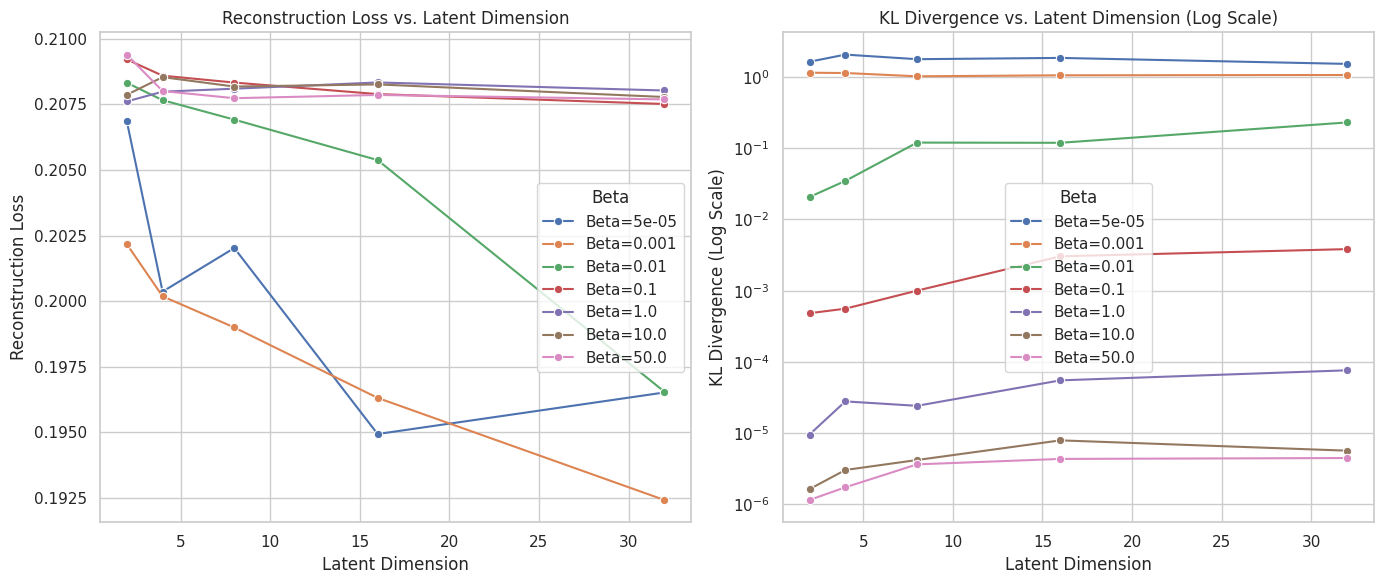

In [41]:
# loss sweep
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cpu'

# Define the hyperparameter grid
latent_dims = [2, 4, 8, 16, 32]
betas = [0.00005, 0.001, 0.01, 0.1, 1.0, 10.0, 50.0]
results = []

# Assuming VAE, compute_metrics, dataloader, and device are defined
num_epochs = 5
learning_rate = 1e-3

for latent_dim in latent_dims:
    for beta in betas:
        # print(f"Training with latent_dim={latent_dim}, beta={beta}")

        # Initialize the model with the current hyperparameters
        model = VAE(latent_dim=latent_dim, beta=beta).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        model = train(model, metrics=False)

        # Evaluate model performance after training
        metrics = compute_metrics(model, dataloader, device)
        # print(f"Metrics for latent_dim={latent_dim}, beta={beta}: {metrics}")

        # Collect results
        results.append(
            {
                "latent_dim": latent_dim,
                "beta": beta,
                "reconstruction_loss": metrics["avg_reconstruction_loss"],
                "kl_divergence": metrics["avg_kl_divergence"],
                "elbo": metrics["elbo"],
            }
        )

# Now you can use the collected results for plotting
plot_loss_metrics(results)

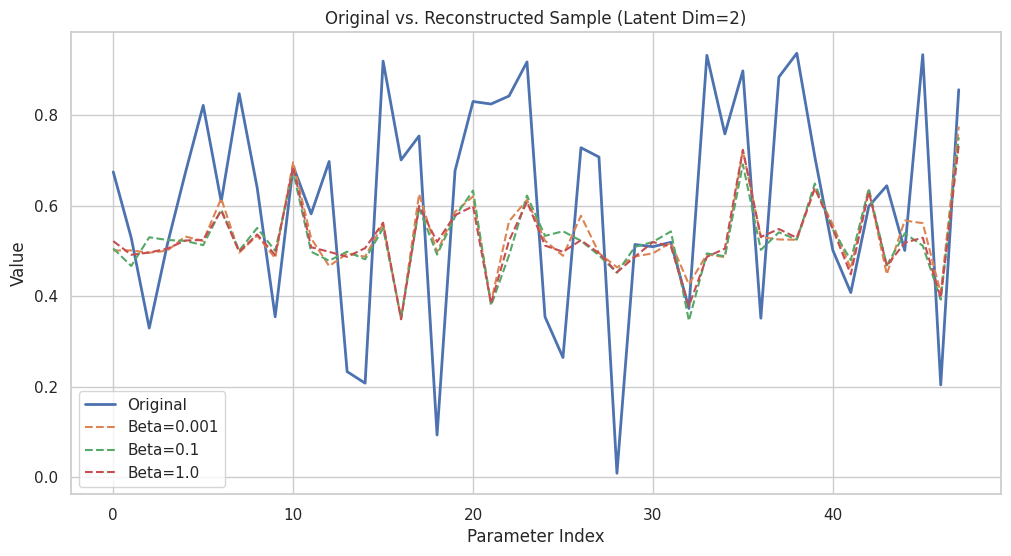

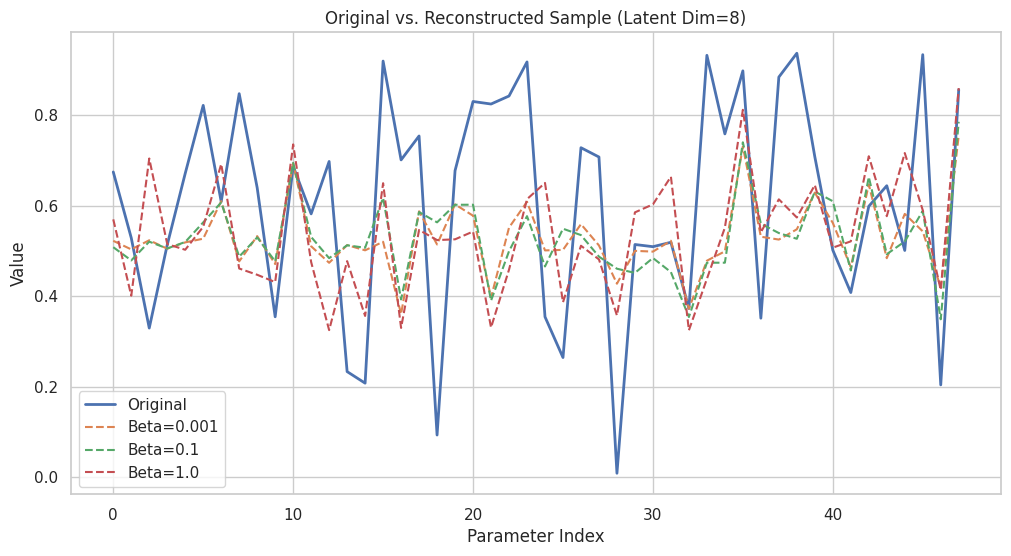

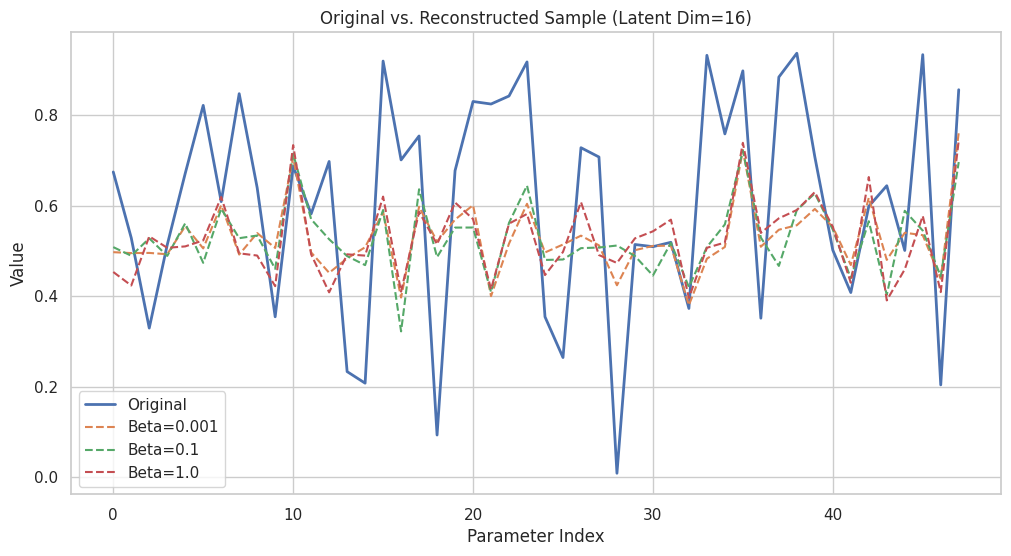

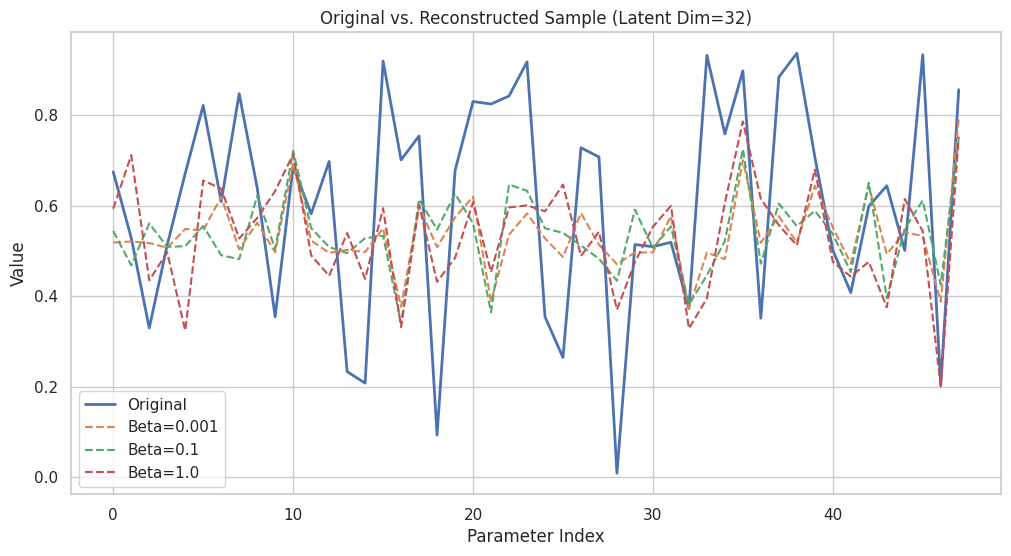

In [39]:
# reconstruction & tsne plots
device = "cpu"
latent_space_results = {}
reconstruction_results = {}
original = None

for latent_dim in [2, 8, 16, 32]:  # Example latent dims
    for beta in [0.001, 0.1, 1.0]:  # Example beta values
        label = f"LatentDim={latent_dim}, Beta={beta}"

        # Assuming train is a function that trains the model and returns the trained VAE
        model = train(VAE(latent_dim=latent_dim, beta=beta), metrics=False)
        inputs = next(iter(dataloader))
        inputs = {
            k: v.to(device) if isinstance(v, torch.Tensor) else v
            for k, v in inputs.items()
        }

        latents, _, _ = model.get_latent(inputs["genome"])
        reconstructions = model(inputs)

        latent_space_results[(latent_dim, beta)] = latents
        reconstruction_results[(latent_dim, beta)] = reconstructions[
            0
        ]  # First sample reconstruction

        # Store the original data to plot against reconstructed data
        if original is None:
            original = inputs["genome"][0]

# Plot latent space grouped by latent dimension
# plot_latent_space_by_dim(latent_space_results)

# Plot reconstruction comparison grouped by latent dimension
plot_reconstruction_comparison_by_dim(original, reconstruction_results)

In [21]:
# generate patch given text
import numpy as np
from collections import defaultdict
import torch

instrument = "Basses"
text = dict(filename=" ".join((instrument,"gritty thick")))

model.eval()
dist = model(text)

sampled_genome = {}

with open(files[instrument][0], "r", encoding="utf-8") as file:
    file_contents = file.read()
patch_scaffold = parse_synplant_patch(file_contents)
patch_scaffold.pop("SynplantPatch")

distribution = instrument_probabilities[instrument]

for i in range(5):
    for (param, prob), pred_prob in zip(distribution.items(), dist):
        sampled_bin = torch.multinomial(pred_prob, 1, replacement=True) / num_bins
        sampled_genome[param] = sampled_bin.item()

    patch_scaffold["genome"] = sampled_genome
    
    # save the patch
    # Check if dir exists, if not create it
    os.makedirs(f"patches/generations", exist_ok=True)
    with open(f"patches/generations/{text['filename']}_{i}.synplant", "w") as file:
        file.write(generate_synplant_patch(patch_scaffold))

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_distributions(model, data_loader, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            predicted_dist = model(inputs)
            
            # Assuming the first distribution in the batch
            pred_dist = predicted_dist[0].cpu().numpy()
            target_dist = inputs['dist'][0].cpu().numpy()
            
            # Plotting predicted distribution
            sns.heatmap(pred_dist.T, ax=axes[i, 0], cmap='viridis')
            axes[i, 0].set_title(f'Predicted Distribution {i+1}')
            axes[i, 0].set_xlabel('Parameters')
            axes[i, 0].set_ylabel('Bins')
            
            # Plotting target distribution
            sns.heatmap(target_dist.T, ax=axes[i, 1], cmap='viridis')
            axes[i, 1].set_title(f'Target Distribution {i+1}')
            axes[i, 1].set_xlabel('Parameters')
            axes[i, 1].set_ylabel('Bins')
    
    plt.tight_layout()
    plt.show()

def visualize_parameter_comparison(model, data_loader, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            
            inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            predicted_dist = model(inputs)
            
            # Assuming the first sample in the batch
            pred_params = torch.argmax(predicted_dist[0], dim=-1).float() / model.num_bins
            target_params = inputs['genome'][0]
            
            pred_params = pred_params.cpu().numpy()
            target_params = target_params.cpu().numpy()
            
            # Plotting parameter comparison
            x = np.arange(len(pred_params))
            axes[i].bar(x - 0.2, pred_params, 0.4, label='Predicted', alpha=0.7)
            axes[i].bar(x + 0.2, target_params, 0.4, label='Target', alpha=0.7)
            axes[i].set_title(f'Parameter Comparison {i+1}')
            axes[i].set_xlabel('Parameter Index')
            axes[i].set_ylabel('Parameter Value')
            axes[i].legend()
            axes[i].set_xticks(x)
    
    plt.tight_layout()
    plt.show()

# Visualize distributions
visualize_distributions(model, dataloader, device)

# Visualize parameter comparisons
visualize_parameter_comparison(model, dataloader, device)